In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
from scipy.ndimage import gaussian_filter


import matplotlib.pyplot as plt
%matplotlib inline

import cartopy.crs as ccrs
import cartopy

from scipy.stats import t,linregress

from precip_model_functions import *

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


# OROGRAPHY GRADIENT

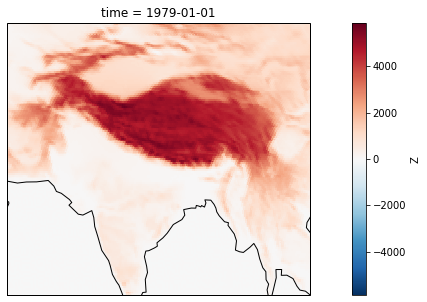

In [4]:
plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
orog.plot(ax=ax,transform=ccrs.PlateCarree())
ax.set_extent(nepal)

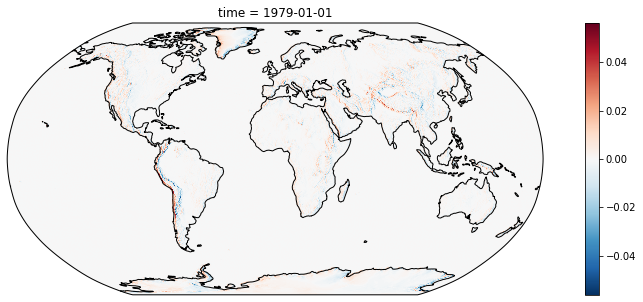

In [5]:
plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ddxorog.plot(ax=ax,transform=ccrs.PlateCarree())
#ax.set_extent(nepal)

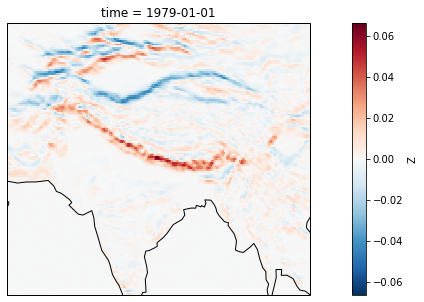

In [6]:
plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ddyorog.plot(ax=ax,transform=ccrs.PlateCarree())
ax.set_extent(nepal)

## Smoothing

0.36079931259155273


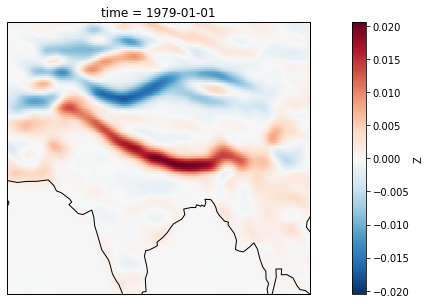

In [5]:
t=time.time()
ddy2=ddyorog_s.sel(longitude=slice(nepals[0],nepals[1]),latitude=slice(nepals[3],nepals[2]))

plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ddy2.plot(ax=ax,transform=ccrs.PlateCarree())
ax.set_extent(nepal)
print(time.time()-t)

In [19]:
def compute_ws(d,latlon):
    u = xr.open_dataset(glob.glob("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.an.pl/*/e5.oper.an.pl.128_131_u.*.%s00_%s23.nc"%(d,d))[0]).U
    v = xr.open_dataset(glob.glob("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.an.pl/*/e5.oper.an.pl.128_132_v.*.%s00_%s23.nc"%(d,d))[0]).V
    #w = xr.open_dataset(glob.glob("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.an.pl/*/e5.oper.an.pl.128_135_w.*.%s00_%s23.nc"%(d,d))[0]).W

    u1 = u.sel(longitude=slice(latlon[0],latlon[1]),latitude=slice(latlon[3],latlon[2]),level=700.).isel(time=[0,5,11,17])
    v1 = v.sel(longitude=slice(latlon[0],latlon[1]),latitude=slice(latlon[3],latlon[2]),level=700.).isel(time=[0,5,11,17])
    #w1 = w.sel(longitude=slice(latlon[0],latlon[1]),latitude=slice(latlon[3],latlon[2]),level=700.).isel(time=[0,5,11,17])
    
    ddx1=ddxorog_s.sel(longitude=slice(latlon[0],latlon[1]),latitude=slice(latlon[3],latlon[2])).isel(time=0)
    ddy1=ddyorog_s.sel(longitude=slice(latlon[0],latlon[1]),latitude=slice(latlon[3],latlon[2])).isel(time=0)
    
    w2 = -0.9*9.81*(u1*ddx1+v1*ddy1)
    
    #return w1.mean("time"),w2.mean("time")
    return w2.mean("time")

def compute_fullws(ds,latlon):
    w1s,w2s=[],[]
    for d in ds:
        w1,w2 = compute_ws(d,latlon)
        w1s.append(w1)
        w2s.append(w2)
    return xr.concat(w1s,'time'),xr.concat(w2s,'time')

def compute_meanws(ds,latlon,lev=1):
    w1s,u1s,v1s=[],[],[]
    t=time.time()
    for d in ds:
        u = xr.open_dataset(glob.glob("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.an.pl/*/e5.oper.an.pl.128_131_u.*.%s00_%s23.nc"%(d,d))[0]).U
        v = xr.open_dataset(glob.glob("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.an.pl/*/e5.oper.an.pl.128_132_v.*.%s00_%s23.nc"%(d,d))[0]).V
        #w = xr.open_dataset(glob.glob("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.an.pl/*/e5.oper.an.pl.128_135_w.*.%s00_%s23.nc"%(d,d))[0]).W
        if lev==1:
            u1 = u.sel(longitude=slice(latlon[0],latlon[1]),latitude=slice(latlon[3],latlon[2]),level=700.).isel(time=range(0,24,timedisc))
            v1 = v.sel(longitude=slice(latlon[0],latlon[1]),latitude=slice(latlon[3],latlon[2]),level=700.).isel(time=range(0,24,timedisc))
            #w1 = w.sel(longitude=slice(latlon[0],latlon[1]),latitude=slice(latlon[3],latlon[2]),level=700.).isel(time=range(0,24,timedisc))
        elif lev==2:
            u1 = u.sel(longitude=slice(latlon[0],latlon[1]),latitude=slice(latlon[3],latlon[2])).isel(time=range(0,24,timedisc),level=range(8,37,leveldisc))
            v1 = v.sel(longitude=slice(latlon[0],latlon[1]),latitude=slice(latlon[3],latlon[2])).isel(time=range(0,24,timedisc),level=range(8,37,leveldisc))
            #w1 = w.sel(longitude=slice(latlon[0],latlon[1]),latitude=slice(latlon[3],latlon[2])).isel(time=range(0,24,timedisc),level=range(8,37,leveldisc))
        u1s.append(u1)
        v1s.append(v1)
        #w1s.append(w1)
    print(time.time()-t)
    u1m = xr.concat(u1s,'time').mean("time")
    print(time.time()-t)
    v1m = xr.concat(v1s,'time').mean("time")
    print(time.time()-t)
    #w1m = xr.concat(w1s,'time').mean("time")
    #print(time.time()-t)
    ddx1=ddxorog_s.sel(longitude=slice(latlon[0],latlon[1]),latitude=slice(latlon[3],latlon[2])).isel(time=0)
    ddy1=ddyorog_s.sel(longitude=slice(latlon[0],latlon[1]),latitude=slice(latlon[3],latlon[2])).isel(time=0)
      
    #return w1m,-0.9*9.81*(u1m*ddx1+v1m*ddy1)
    return -0.9*9.81*(u1m*ddx1+v1m*ddy1)
    
    
    
def compute_corrws(ds,latlon):
    t=time.time()
    w1s,w2s=[],[]
    for d in ds:
        w1,w2 = compute_ws(d,latlon)
        w1s.append(w1)
        w2s.append(w2)
    print(time.time()-t)
    w1c = xr.concat(w1s,'time')
    w2c = xr.concat(w2s,'time')
    w1m = w1c.mean()
    w2m = w2c.mean()
    prod = (w1c - w1m)*(w2c-w2m)
    vw1 = (w1c - w1m)**2
    vw2 = (w2c - w2m)**2
    print(time.time()-t)
    return prod.sum("time")/np.sqrt(vw1.sum("time")*vw2.sum("time"))
     

In [63]:
latlon = nepal1
ct = "nepal"
for d in ["19980706","19990710"] :
        dp = pd.to_datetime(d, format='%Y%m%d')
        ds = [(dp + pd.Timedelta(days=i)).strftime("%Y%m%d") for i in range(-2,3)]   
        omega = compute_meanws(ds,latlon)
        omega.to_netcdf("/global/cscratch1/sd/qnicolas/precipmodel/omega/e5.upslopeomega700.%s.%s.nc"%(d,ct))       
        print("Done ",d)
 

6.718479871749878
24.644611597061157
43.21669602394104
Done  19980706
7.007836580276489
24.2465078830719
42.283432960510254
Done  19990710


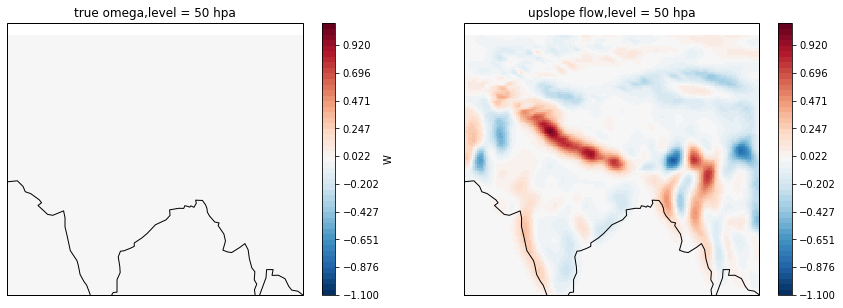

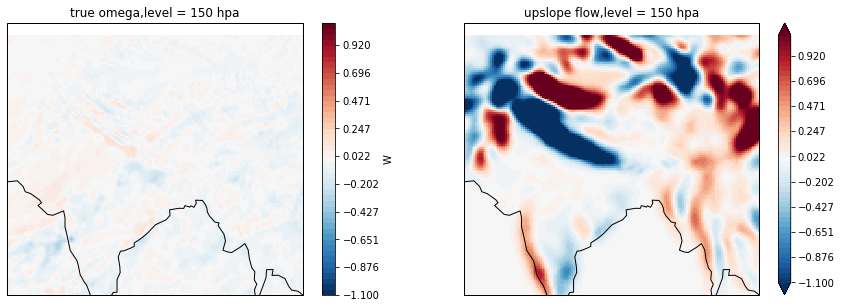

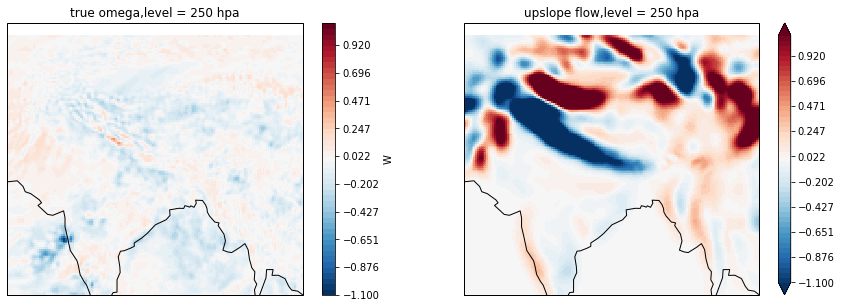

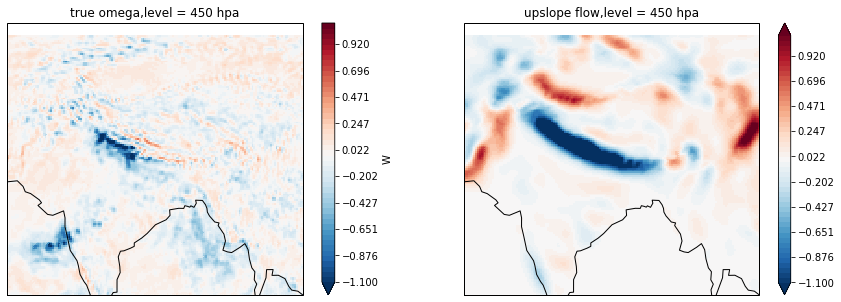

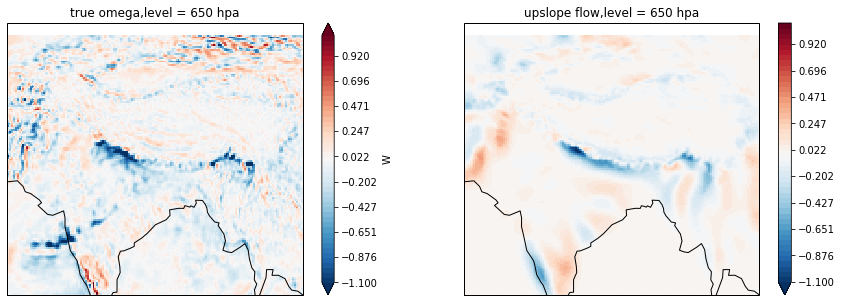

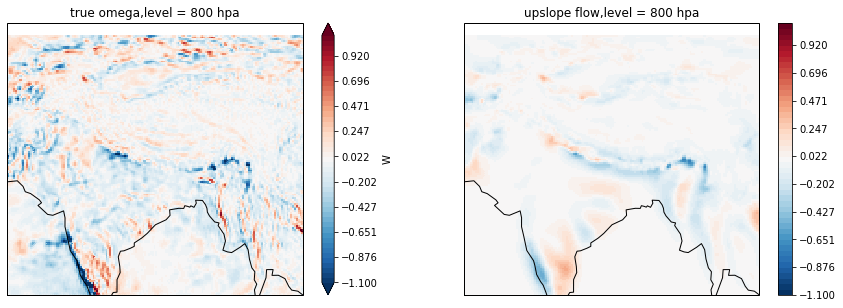

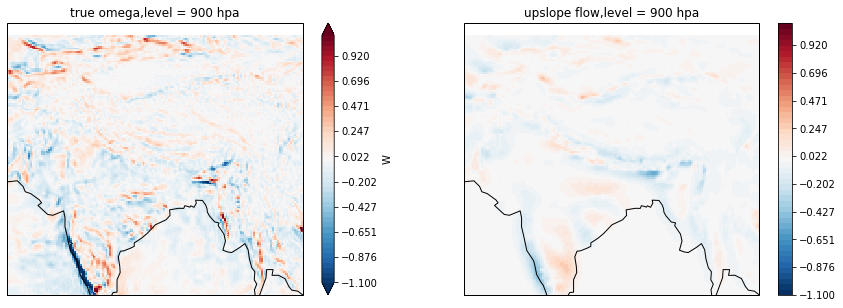

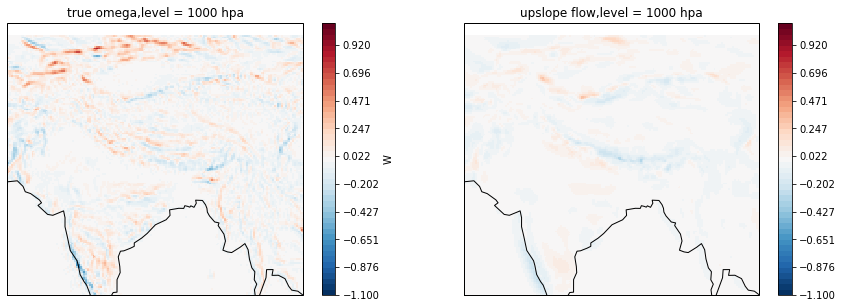

In [29]:
country=nepal
for i in range(len(w1_500.level)):
    w1_alla = w1_all.isel(level=i)
    w2_alla = w2_all.isel(level=i)

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),subplot_kw={'projection': ccrs.PlateCarree()})
    
    extent=1.1
    
    ax1.coastlines()
    w1_alla.plot(ax=ax1,transform=ccrs.PlateCarree(),levels=np.linspace(-extent,extent,50))
    ax1.set_extent(country)
    ax1.set_title("true omega,level = %i hpa"%w1_all.level[i])
    
    ax2.coastlines()
    w2_alla.plot(ax=ax2,transform=ccrs.PlateCarree(),levels=np.linspace(-extent,extent,50))
    ax2.set_extent(country)
    ax2.set_title("upslope flow,level = %i hpa"%w1_all.level[i])

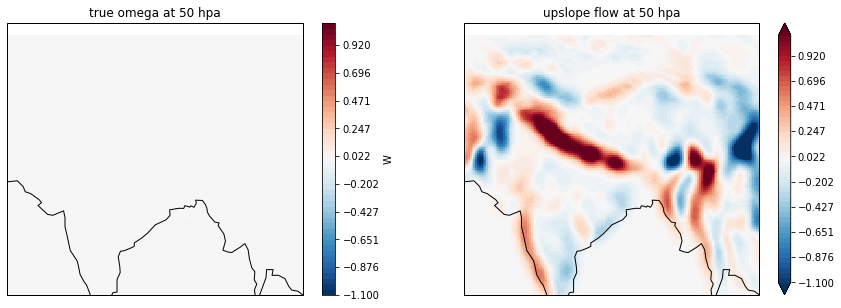

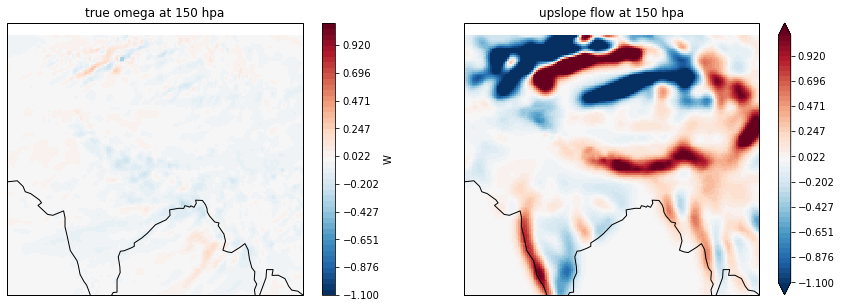

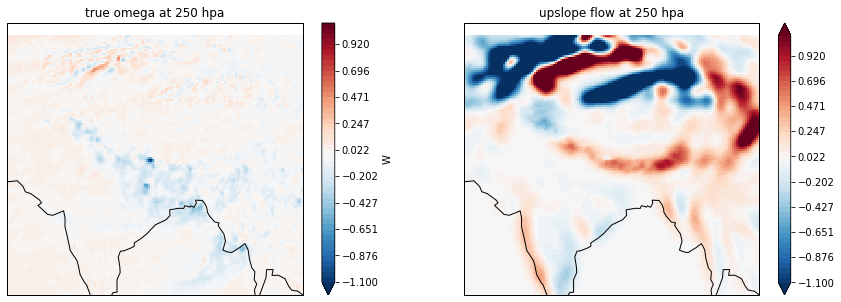

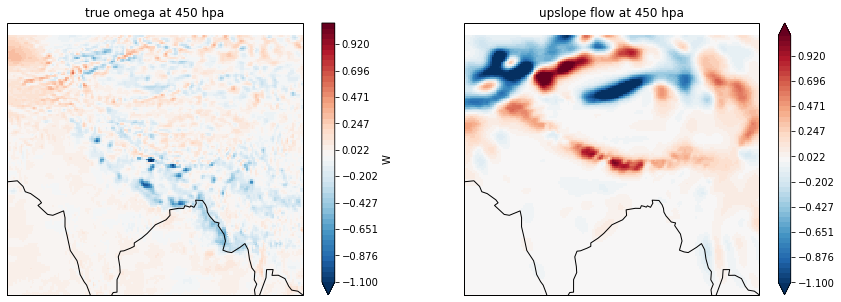

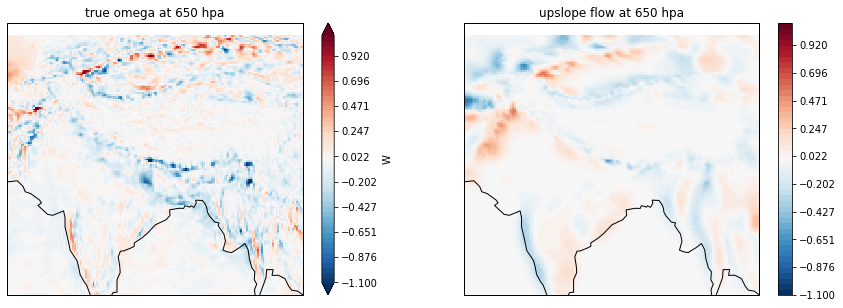

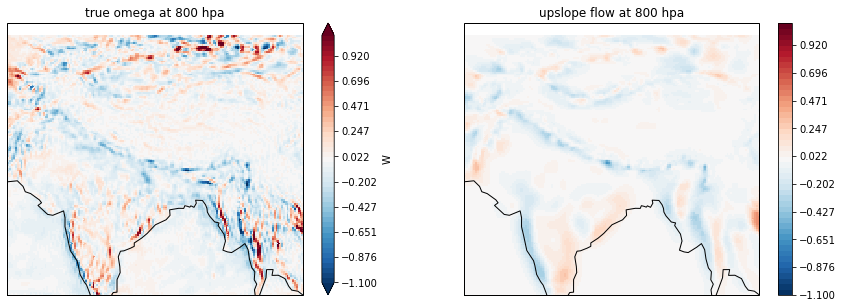

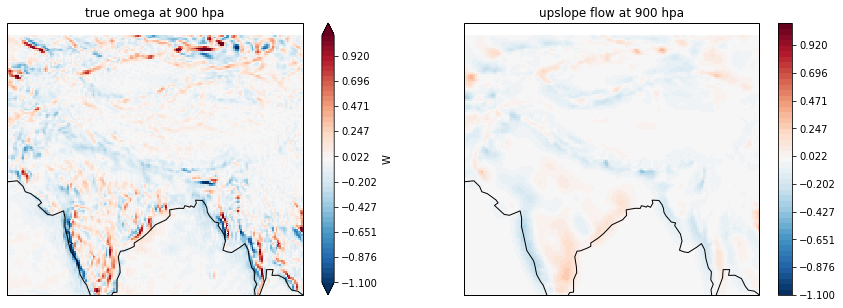

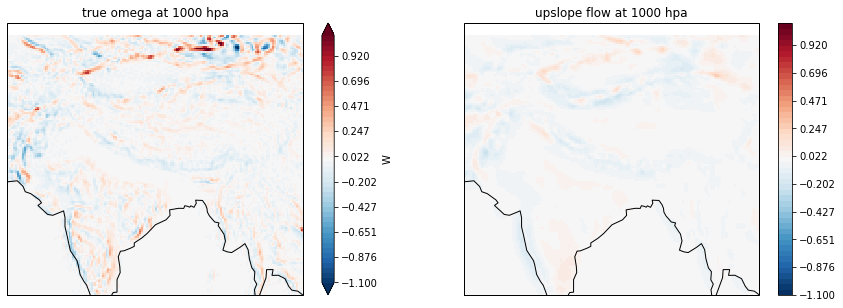

In [31]:
country=nepal
for i in range(len(w1_500.level)):
    w1_alla = w1_all.isel(level=i)
    w2_alla = w2_all.isel(level=i)

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),subplot_kw={'projection': ccrs.PlateCarree()})
    
    extent=1.1
    
    ax1.coastlines()
    w1_alla.plot(ax=ax1,transform=ccrs.PlateCarree(),levels=np.linspace(-extent,extent,50))
    ax1.set_extent(country)
    ax1.set_title("true omega,level = %i hpa"%w1_all.level[i])
    
    ax2.coastlines()
    w2_alla.plot(ax=ax2,transform=ccrs.PlateCarree(),levels=np.linspace(-extent,extent,50))
    ax2.set_extent(country)
    ax2.set_title("upslope flow,level = %i hpa"%w1_all.level[i])

## Vertical profiles of omega for 2000 and 2006 rx5 events in nepal

In [8]:
def spacemean_era5(ds,latlon):
    return ds.sel(longitude=slice(latlon[0],latlon[1]),latitude=slice(latlon[3],latlon[2])).mean(["latitude","longitude"])

(1010, 0)

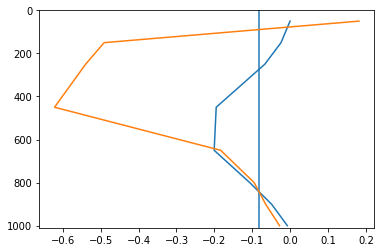

In [9]:
w1_lev = spacemean_era5(w1_all0,nepal1)
w2_lev = spacemean_era5(w2_all0,nepal1)

plt.plot(w1_lev,w1_lev.level)
plt.axvline(w1_lev.mean("level"))
plt.plot(w2_lev,w2_lev.level)
plt.gca().set_ylim(1010, 0)

(1010, 0)

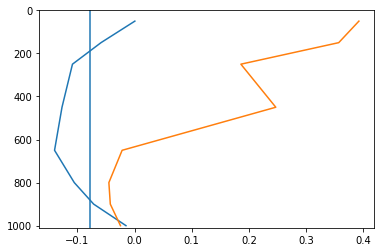

In [10]:
w1_lev = spacemean_era5(w1_all,nepal1)
w2_lev = spacemean_era5(w2_all,nepal1)

plt.plot(w1_lev,w1_lev.level)
plt.axvline(w1_lev.mean("level"))
plt.plot(w2_lev,w2_lev.level)
plt.gca().set_ylim(1010, 0)

## Vertical profiles of omega for 2000 and 2006 rx5 events in nepal

In [15]:
d =  rx5nepal[:6]
latlon =nepal

t=time.time()
w1_all0,w2_all0 = compute_meanws(d,latlon,2)
print(time.time()-t)

18.636314868927002
161.5025017261505
324.067547082901
460.1149263381958
460.1465120315552


Text(0.5, 1.0, 'first six rx5 events in chile')

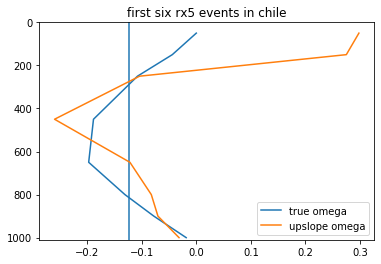

In [22]:
w1_lev = spacemean_era5(w1_all0,nepal1)
w2_lev = spacemean_era5(w2_all0,nepal1)

w1_leva = np.array(w1_lev)
p = np.array(w1_lev.level)
w1_mean=np.sum((w1_leva[:-1]+w1_leva[1:])*(p[1:]-p[:-1]))/(p[-1]-p[0])/2

#w1_lev.mean("level")

plt.plot(w1_lev,w1_lev.level,label="true omega")
plt.axvline(w1_mean)
plt.plot(w2_lev,w2_lev.level,label="upslope omega")
plt.gca().set_ylim(1010, 0)
plt.legend()
plt.title("first six rx5 events in chile")

In [18]:
np.array(w1_lev)

array([ 2.04891494e-05, -4.39918153e-02, -1.07812956e-01, -1.88489258e-01,
       -1.97294071e-01, -1.30850017e-01, -7.78899863e-02, -1.85163021e-02],
      dtype=float32)

# Mean upslope flow vs mean true omega over rx5 events for nepal, mexico and chile

In [32]:
d =  rx5pakistan
country=pakistan
latlon =pakistans

w1_500,w2_500 = compute_meanws(d,latlon)

Text(0.5, 1.0, 'upslope flow')

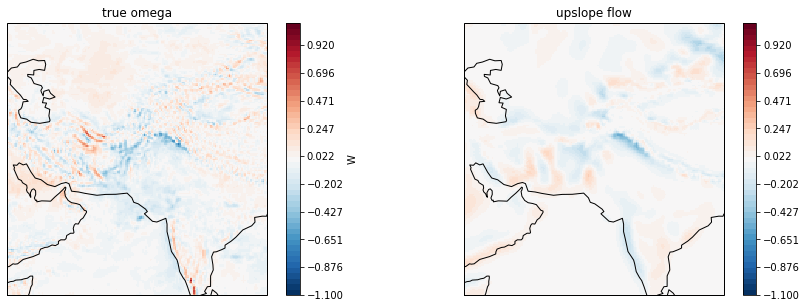

In [34]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),subplot_kw={'projection': ccrs.PlateCarree()})

extent=1.1

ax1.coastlines()
w1_500.plot(ax=ax1,transform=ccrs.PlateCarree(),levels=np.linspace(-extent,extent,50))
ax1.set_extent(country)
ax1.set_title("true omega")

ax2.coastlines()
w2_500.plot(ax=ax2,transform=ccrs.PlateCarree(),levels=np.linspace(-extent,extent,50))
ax2.set_extent(country)
ax2.set_title("upslope flow")

In [35]:
d =  rx5mexico
country=mexico
latlon =mexicos

w1_500,w2_500 = compute_meanws(d,latlon)

Text(0.5, 1.0, 'upslope flow')

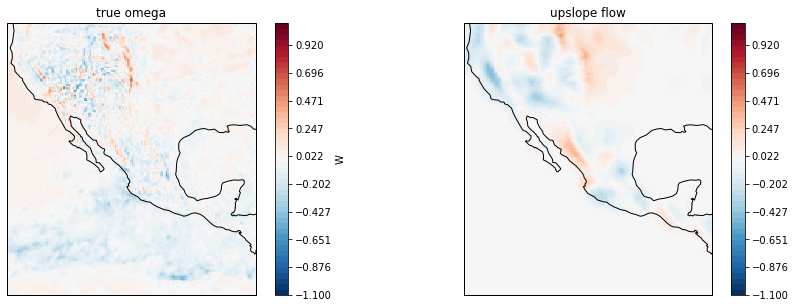

In [36]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),subplot_kw={'projection': ccrs.PlateCarree()})

extent=1.1

ax1.coastlines()
w1_500.plot(ax=ax1,transform=ccrs.PlateCarree(),levels=np.linspace(-extent,extent,50))
ax1.set_extent(country)
ax1.set_title("true omega")

ax2.coastlines()
w2_500.plot(ax=ax2,transform=ccrs.PlateCarree(),levels=np.linspace(-extent,extent,50))
ax2.set_extent(country)
ax2.set_title("upslope flow")

In [10]:
d =  rx5chile
country=chile
latlon =chiles

w1_500,w2_500 = compute_meanws(d,latlon)

Text(0.5, 1.0, 'upslope flow')

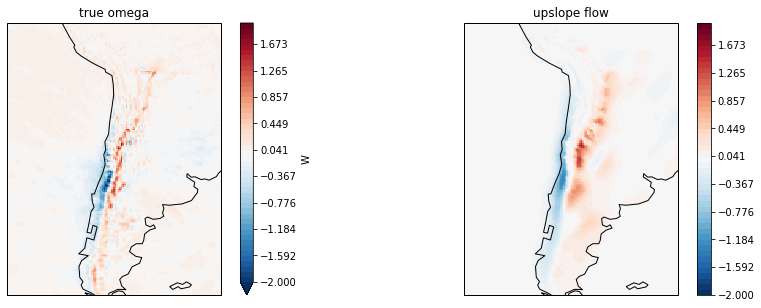

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),subplot_kw={'projection': ccrs.PlateCarree()})

extent=2

ax1.coastlines()
w1_500.plot(ax=ax1,transform=ccrs.PlateCarree(),levels=np.linspace(-extent,extent,50))
ax1.set_extent(country)
ax1.set_title("true omega")

ax2.coastlines()
w2_500.plot(ax=ax2,transform=ccrs.PlateCarree(),levels=np.linspace(-extent,extent,50))
ax2.set_extent(country)
ax2.set_title("upslope flow")

## Per-grid-cell temporal correlation between true omega and upslope flow

In [24]:
d =  rx5nepal
country=nepal
latlon =nepals
corr = compute_corrws(d,latlon)

163.82251572608948
163.8666741847992


In [17]:
nyears = 14
p = 0.05
t_thresh = t.ppf(1-p/2,nyears-2)
r_thresh = t_thresh/np.sqrt(nyears-2+t_thresh**2)
print(r_thresh)

0.5324128046806423


Text(0.5, 1.0, 'correlation coef')

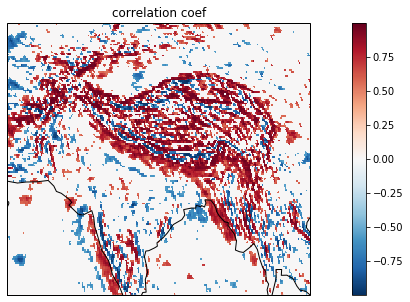

In [25]:
corr_filtered=(1*(np.abs(corr)>r_thresh))*corr

plt.figure(figsize=(15,5))
ax1 = plt.axes(projection=ccrs.Robinson())
ax1.coastlines()
corr_filtered.plot(ax=ax1,transform=ccrs.PlateCarree())
ax1.set_extent(country)
ax1.set_title("correlation coef")

In [20]:
d =  rx5chile
country=chile
latlon =chiles
corr = compute_corrws(d,latlon)

163.29926228523254
163.35065960884094


Text(0.5, 1.0, 'correlation coef')

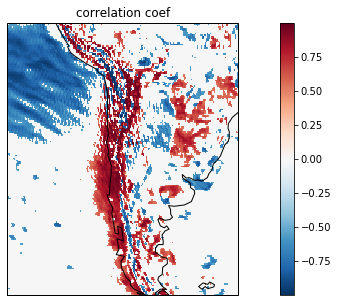

In [23]:
corr_filtered=(1*(np.abs(corr)>r_thresh))*corr

plt.figure(figsize=(15,5))
ax1 = plt.axes(projection=ccrs.Robinson())
ax1.coastlines()
corr_filtered.plot(ax=ax1,transform=ccrs.PlateCarree())
ax1.set_extent(country)
ax1.set_title("correlation coef")

In [14]:
d =  rx5nepal
country=nepal
latlon =nepals

t=time.time()
w1_500n,w2_500n = compute_fullws(d,latlon)
print(time.time()-t)

192.27984309196472


In [15]:
a=xr.apply_ufunc(lr,w1_500,w2_500,input_core_dims=[['time'], ['time']],vectorize=True)
p=xr.apply_ufunc(lrp,w1_500,w2_500,input_core_dims=[['time'], ['time']],vectorize=True)

Text(0.5, 1.0, 'linear regression slope, capped at 2')

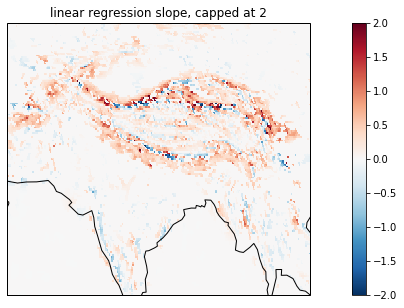

In [17]:
ap = a*(1*(p<0.05))
th=2
ap=np.maximum(np.minimum(ap,th),-th)


plt.figure(figsize=(15,5))
ax1 = plt.axes(projection=ccrs.Robinson())
ax1.coastlines()
ap.plot(ax=ax1,transform=ccrs.PlateCarree())
ax1.set_extent(country)
ax1.set_title("linear regression slope, capped at 2")

In [20]:
d =  rx5chile
country=chile
latlon =chiles

t=time.time()
w1_500c,w2_500c = compute_fullws(d,latlon)
print(time.time()-t)

192.79796242713928


In [9]:
a=xr.apply_ufunc(lr,w1_500c,w2_500c,input_core_dims=[['time'], ['time']],vectorize=True)
p=xr.apply_ufunc(lrp,w1_500c,w2_500c,input_core_dims=[['time'], ['time']],vectorize=True)

Text(0.5, 1.0, 'correlation coef')

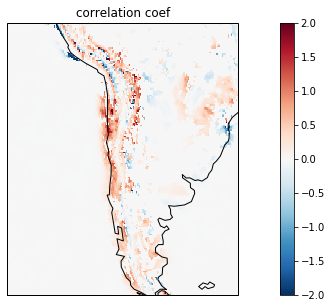

In [13]:
ap = a*(1*(p<0.05))
th=2
ap=np.maximum(np.minimum(ap,th),-th)

plt.figure(figsize=(15,5))
ax1 = plt.axes(projection=ccrs.Robinson())
ax1.coastlines()
ap.plot(ax=ax1,transform=ccrs.PlateCarree())
ax1.set_extent(country)
ax1.set_title("linear regression slope, capped at 2")

## (Mean omega over box) vs (mean upslope flow) temporal Regression slope, Nepal, 3 boxes (divided in horizontal), 3 upslope flow models, all levels

In [21]:
ds =  rx5Sandes
latlon = Sandes1
ct =    "Sandes"
omegas = retrieveomega(ds,latlon,ct,["oper.an.pl.128_135_w.ll025sc","omegaupslopemean200","omegaupslopesin","omegaupslope700"])


### Upslope omega at 700 hpa

Text(0, 0.5, 'omega_upslope 700hpa Sandes')

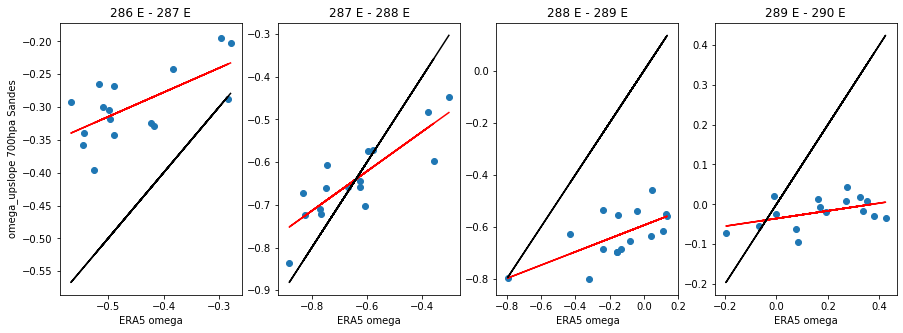

In [23]:

n=4


dl = (latlon[1]-latlon[0])/n
omegatrue = np.array([[np.array(omegas[0][j].sel(longitude=slice(latlon[0]+i*dl,latlon[0]+(i+1)*dl),latitude=slice(latlon[3],latlon[2])).sel(level=650.).mean(["latitude","longitude"]).to_array())[0] for j in range(len(omegas[0]))] for i in range(n)])
omega700  = np.array([[np.array(omegas[3][j].sel(longitude=slice(latlon[0]+i*dl,latlon[0]+(i+1)*dl),latitude=slice(latlon[3],latlon[2])).isel(level=0).mean(["latitude","longitude"]).to_array())[0] for j in range(len(omegas[0]))] for i in range(n)])
#
#dl = (latlon[3]-latlon[2])/n
#omegatrue = np.array([[np.array(omegas[0][j].sel(longitude=slice(latlon[0],latlon[1]),latitude=slice(latlon[2]+(i+1)*dl,latlon[2]+i*dl)).sel(level=650.).mean(["latitude","longitude"]).to_array())[0] for j in range(len(omegas[0]))] for i in range(n)])
#omega700  = np.array([[np.array(omegas[3][j].sel(longitude=slice(latlon[0],latlon[1]),latitude=slice(latlon[2]+(i+1)*dl,latlon[2]+i*dl)).isel(level=0).mean(["latitude","longitude"]).to_array())[0] for j in range(len(omegas[0]))] for i in range(n)])



f,ax = plt.subplots(1,n,figsize=(15,5))
ax=ax.reshape(-1)
for i in range(n):
    l = linregress(omegatrue[i,:],omega700[i,:])
    ax[i].plot(omegatrue[i,:],l.intercept+l.slope*omegatrue[i,:],"r")
    ax[i].plot(omegatrue[i,:],omegatrue[i,:],"k")
    ax[i].scatter(omegatrue[i,:],omega700[i,:])
    ax[i].set_title("%i E - %i E"%(latlon[0]+i*dl,latlon[0]+(i+1)*dl))
    ax[i].set_xlabel('ERA5 omega')
ax[0].set_ylabel("omega_upslope 700hpa " + ct)

### Mean upslope omega over [ps -- ps+200mb]

(3, 4, 8, 16)


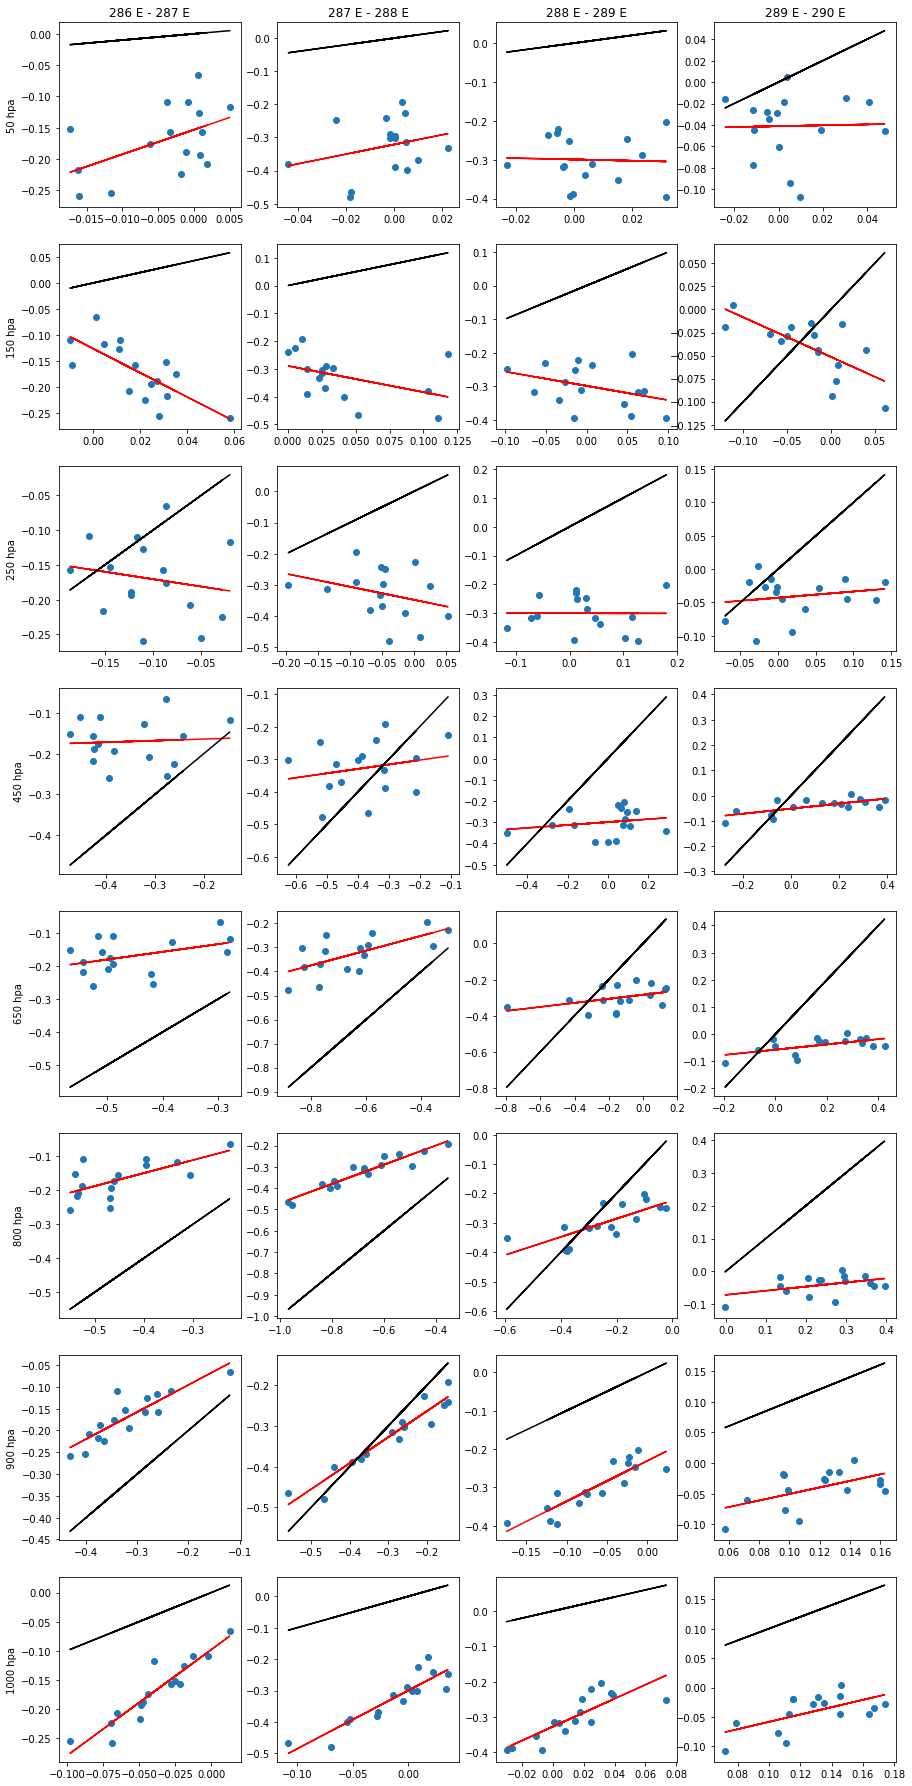

In [24]:

n=4
dl = (latlon[1]-latlon[0])/n
nl=len(omegas[0][0].level)
levs = omegas[0][0].level

# dimensions  = models * slices * levels * times
omega = np.array([[[[np.array(omegas[m][j].sel(longitude=slice(latlon[0]+i*dl,latlon[0]+(i+1)*dl),latitude=slice(latlon[3],latlon[2])).isel(level=l).mean(["latitude","longitude"]).to_array())[0] for j in range(len(omegas[0]))] for l in range(nl)] for i in range(n)] for m in range(len(omegas)-1)])

print(omega.shape)

f,ax = plt.subplots(nl,n,figsize=(15,4*nl))

for i in range(n):
    for l in range(nl):
        lrg = linregress(omega[0,i,l,:],omega[1,i,l,:])
        ax[l][i].plot(omega[0,i,l,:],lrg.intercept+lrg.slope*omega[0,i,l,:],"r")
        ax[l][i].plot(omega[0,i,l,:],omega[0,i,l,:],"k")
        ax[l][i].scatter(omega[0,i,l,:],omega[1,i,l,:])
        ax[l][0].set_ylabel('%i hpa'%levs[l])
    #ax[i].set_aspect('equal', adjustable='box')
    ax[0][i].set_title("%i E - %i E"%(latlon[0]+i*dl,latlon[0]+(i+1)*dl))

### Sinusoidal upslope omega

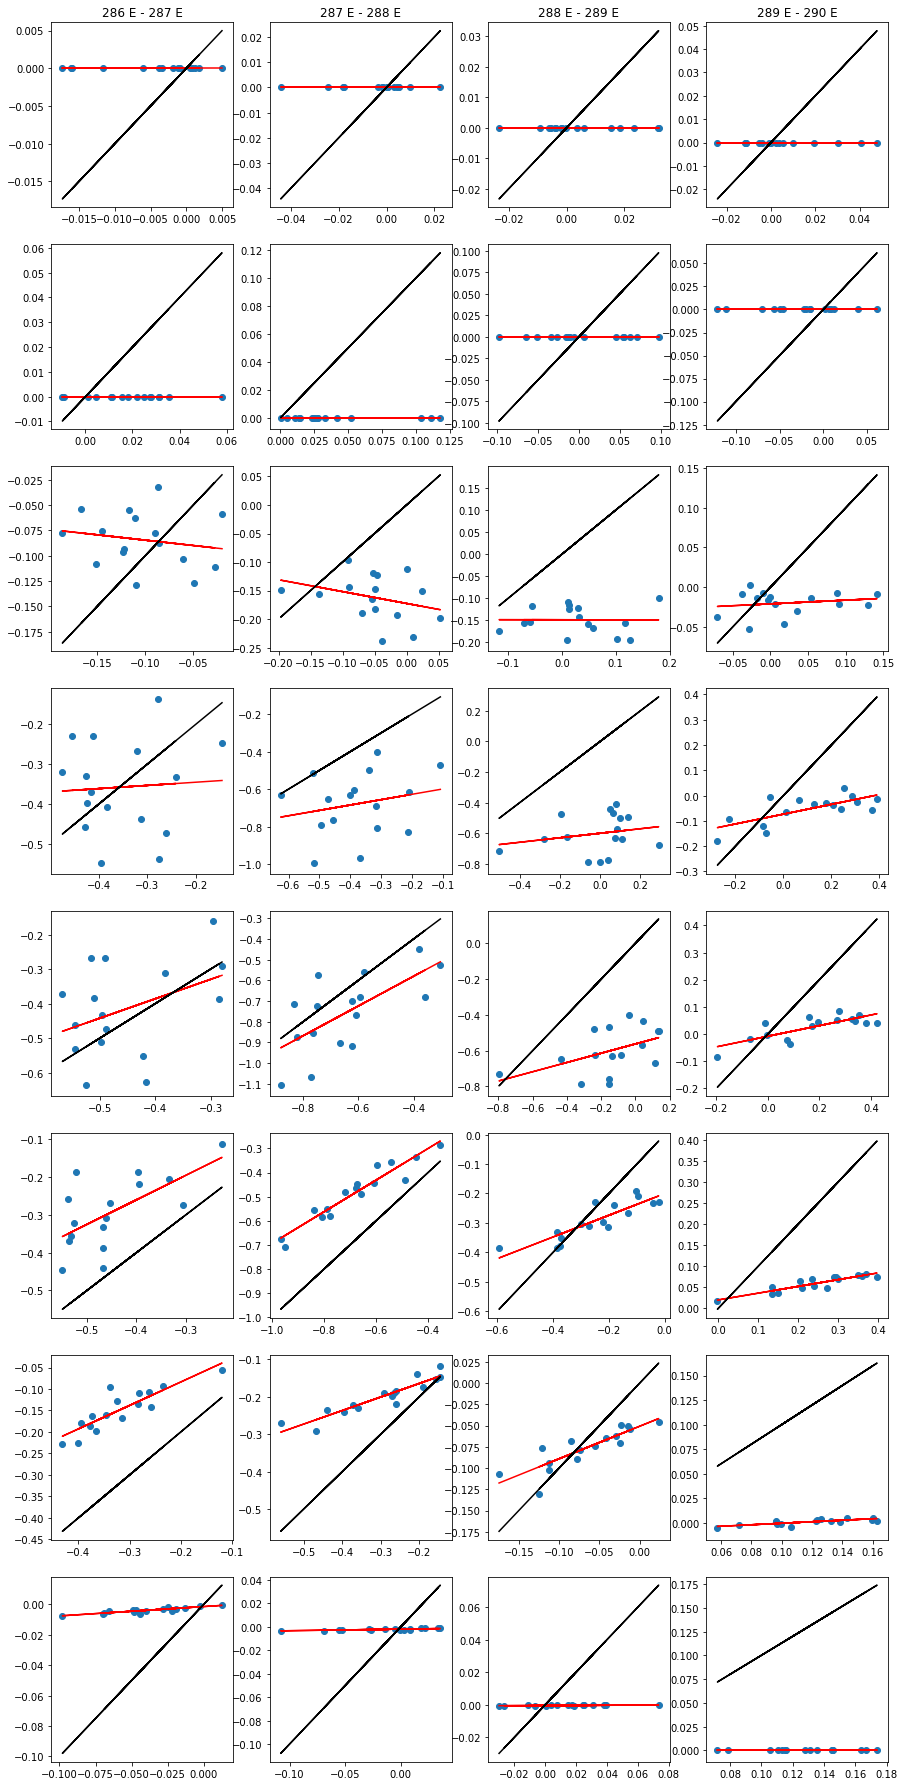

In [26]:
n=4
dl = (latlon[1]-latlon[0])/n
nl=len(omegas[0][0].level)
# dimensions  = models * slices * levels * times
omega = np.array([[[[np.array(omegas[m][j].sel(longitude=slice(latlon[0]+i*dl,latlon[0]+(i+1)*dl),latitude=slice(latlon[3],latlon[2])).isel(level=l).mean(["latitude","longitude"]).to_array())[0] for j in range(len(omegas[0]))] for l in range(nl)] for i in range(n)] for m in range(len(omegas)-1)])

f,ax = plt.subplots(nl,n,figsize=(15,4*nl))

for i in range(n):
    for l in range(nl):
        lrg = linregress(omega[0,i,l,:],omega[2,i,l,:])
        ax[l][i].plot(omega[0,i,l,:],lrg.intercept+lrg.slope*omega[0,i,l,:],"r")
        ax[l][i].plot(omega[0,i,l,:],omega[0,i,l,:],"k")
        ax[l][i].scatter(omega[0,i,l,:],omega[2,i,l,:])
    #ax[i].set_aspect('equal', adjustable='box')
    ax[0][i].set_title("%i E - %i E"%(latlon[0]+i*dl,latlon[0]+(i+1)*dl))
    

In [41]:
print("r")

r
